In [1]:
import pickle

import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

##### 
import warnings
warnings.filterwarnings("ignore")
#####

from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *

In [2]:
oup_fname = '../data/input/universe_Planck15/camb/CAMB_outputs.pkl'
print(oup_fname)
f = open(oup_fname, 'rb') 
powers,cl,c_lensed,c_lens_response = pickle.load(f)
f.close()

totCL=powers['total']
unlensedCL=powers['unlensed_scalar']

L = np.arange(unlensedCL.shape[0])

unlensedTT = unlensedCL[:,0]/(L*(L+1))*2*np.pi
F = unlensedTT
funlensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(cl.shape[0])
PP = cl[:,0]
rawPP = PP*2*np.pi/((L*(L+1))**2)
rawKK = L**4/4 * rawPP

fKK = interp1d(L, rawKK, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(totCL.shape[0])

lensedTT = totCL[:,0]/(L*(L+1))*2*np.pi
F = lensedTT
flensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)


ftot = lambda l : flensedTT(l) + cmb.fForeground(l) + cmb.fdetectorNoise(l)
ftot = lambda l : flensedTT(l) + cmb.fForeground(l) + cmb.fdetectorNoise(l)


with open('f_aniso_ftot_worst_case.pkl', 'rb') as f:
    ftot = pickle.load(f)
print('loaded estimated ftot')



L = np.arange(c_lens_response.shape[0])

cTgradT = c_lens_response.T[0]/(L*(L+1))*2*np.pi

fTgradT = interp1d(L, cTgradT, kind='linear', bounds_error=False, fill_value=0.)

../data/input/universe_Planck15/camb/CAMB_outputs.pkl
loaded estimated ftot


In [3]:



#####
N_runs = 2000

process = True
# number of pixels for the flat map
nX = 1200
nY = 1200
# map dimensions in degrees
sizeX = 20.
sizeY = 20.

#####


print("Map properties")


mean_field = None


# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
lRange = (1., 2.*lMax)  # range for power spectra

print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: ftot(l) 

# reinterpolate: gain factor 10 in speed
# L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
# F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = ftot

print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)

Map properties
CMB experiment properties
Gets a theoretical prediction for the noise
computing the reconstruction noise


In [4]:
def gen_clFourier(fcur):
    f = lambda l: np.sqrt(fcur(l))
    clFourier = np.array(list(map(f, baseMap.l.flatten())))
    clFourier = np.nan_to_num(clFourier)
    clFourier = clFourier.reshape(np.shape(baseMap.l))
    return clFourier


clFourier_ftot = gen_clFourier(ftot)
clFourier_funlensedTT = gen_clFourier(funlensedTT)
clFourier_fKK = gen_clFourier(fKK)
clFourier_fForeground = gen_clFourier(cmb.fForeground)
clFourier_fdetectorNoise = gen_clFourier(cmb.fdetectorNoise)
print('precomputed cl')

precomputed cl


In [5]:
nBins=51
def combine_sketchy(Cl0, Cli):
    n_runs = np.shape(Cl0)[0]
#     print(n_runs, np.shape(Cl0))
    ret = np.copy(Cl0)
    ret = np.transpose(ret, axes=[1,2,0])
    ret[1] = np.array([
        [Cl0[run_idx][1][bin_idx]+
         sum([Cli[i][run_idx][1][bin_idx] for i in range(len(Cli))]) 
                     for run_idx in range(n_runs)] 
                    for bin_idx in range(len(Cl0[0][1]))])
    ret[2] = np.array([[np.sqrt(Cl0[run_idx][2][bin_idx]**2+sum([Cli[i][run_idx][2][bin_idx]**2 
                                                               for i in range(len(Cli))]))
                     for run_idx in range(n_runs)] 
                    for bin_idx in range(len(Cl0[0][1]))])
    return np.transpose(ret, axes=[2,0,1])

In [19]:
from multiprocessing import Pool
from tqdm import trange, tqdm
errmap = None

with open('anisotropic_noise_map_worst_case.pkl', 'rb') as f:
    errmap = pickle.load(f)


def process_run(idx):
    np.random.seed(idx+609238472)
    cmb0Fourier = baseMap.genGRF(funlensedTT, 
                                 clFourier=clFourier_funlensedTT)
    cmb0 = baseMap.inverseFourier(cmb0Fourier)

    
    
    kCmbFourier = baseMap.genGRF(fKK, 
                                 clFourier=clFourier_fKK)
    kCmb = baseMap.inverseFourier(kCmbFourier)
    
    

    lensedCmb = baseMap.doLensing(cmb0, kappaFourier=kCmbFourier)
    lensedCmbFourier = baseMap.fourier(lensedCmb)
    
    

    fgFourier = baseMap.genGRF(cmb.fForeground, 
                               clFourier=clFourier_fForeground)
    lensedCmbFourier = lensedCmbFourier + fgFourier
    
    
    lensedCmb = baseMap.inverseFourier(lensedCmbFourier)


    
    noiseFourier = baseMap.genGRF(cmb.fdetectorNoise, 
                                  clFourier=clFourier_fdetectorNoise)
    
    totalCmbFourier_noiseless = lensedCmbFourier + noiseFourier

    sqNhat_um = baseMap.computeQuadEstKappaAutoCorrectionMap(fTgradT,
                                                        cmb.fCtotal, 
                                                        lMin=lMin, lMax=lMax, 
                                                        dataFourier=totalCmbFourier_noiseless)

    aniso_noise = baseMap.inverseFourier(noiseFourier) / np.min(errmap)
    aniso_noise = aniso_noise * errmap # apply errmap
    aniso_noise_fourier = baseMap.fourier(aniso_noise)

 
    totalCmbFourier = lensedCmbFourier + aniso_noise_fourier
    totalCmb = baseMap.inverseFourier(totalCmbFourier)
    sqNhat = baseMap.computeQuadEstKappaAutoCorrectionMap(fTgradT,
                                                        cmb.fCtotal, 
                                                        lMin=lMin, lMax=lMax, 
                                                        dataFourier=totalCmbFourier)
    MM = [-1,-1,-1]
    MM[0], MM[1], MM[2] = baseMap.powerSpectrum(dataFourier=sqNhat, nBins=nBins)
            
    UM = [-1,-1,-1]
    UM[0],UM[1],UM[2] = baseMap.powerSpectrum(dataFourier=sqNhat_um, nBins=nBins)
    deltaMask = combine_sketchy(np.array([MM]), [-np.array([UM])])

    
    

    return deltaMask[0]


with Pool() as pool:
    results = list(tqdm(pool.imap(process_run, range(N_runs)), total=N_runs))
mean_field = sum(results)

100%|██████████| 2000/2000 [09:08<00:00,  3.65it/s]


In [20]:
np.array(results).shape

(2000, 3, 50)

In [21]:
def combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/n_runs
#     sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))/n_runs
    sCls = np.std(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/np.sqrt(n_runs)
    return lCen, Cls, sCls

In [22]:
deltaMask_mean = combine_Cl(results)

2000 (2000, 3, 50)


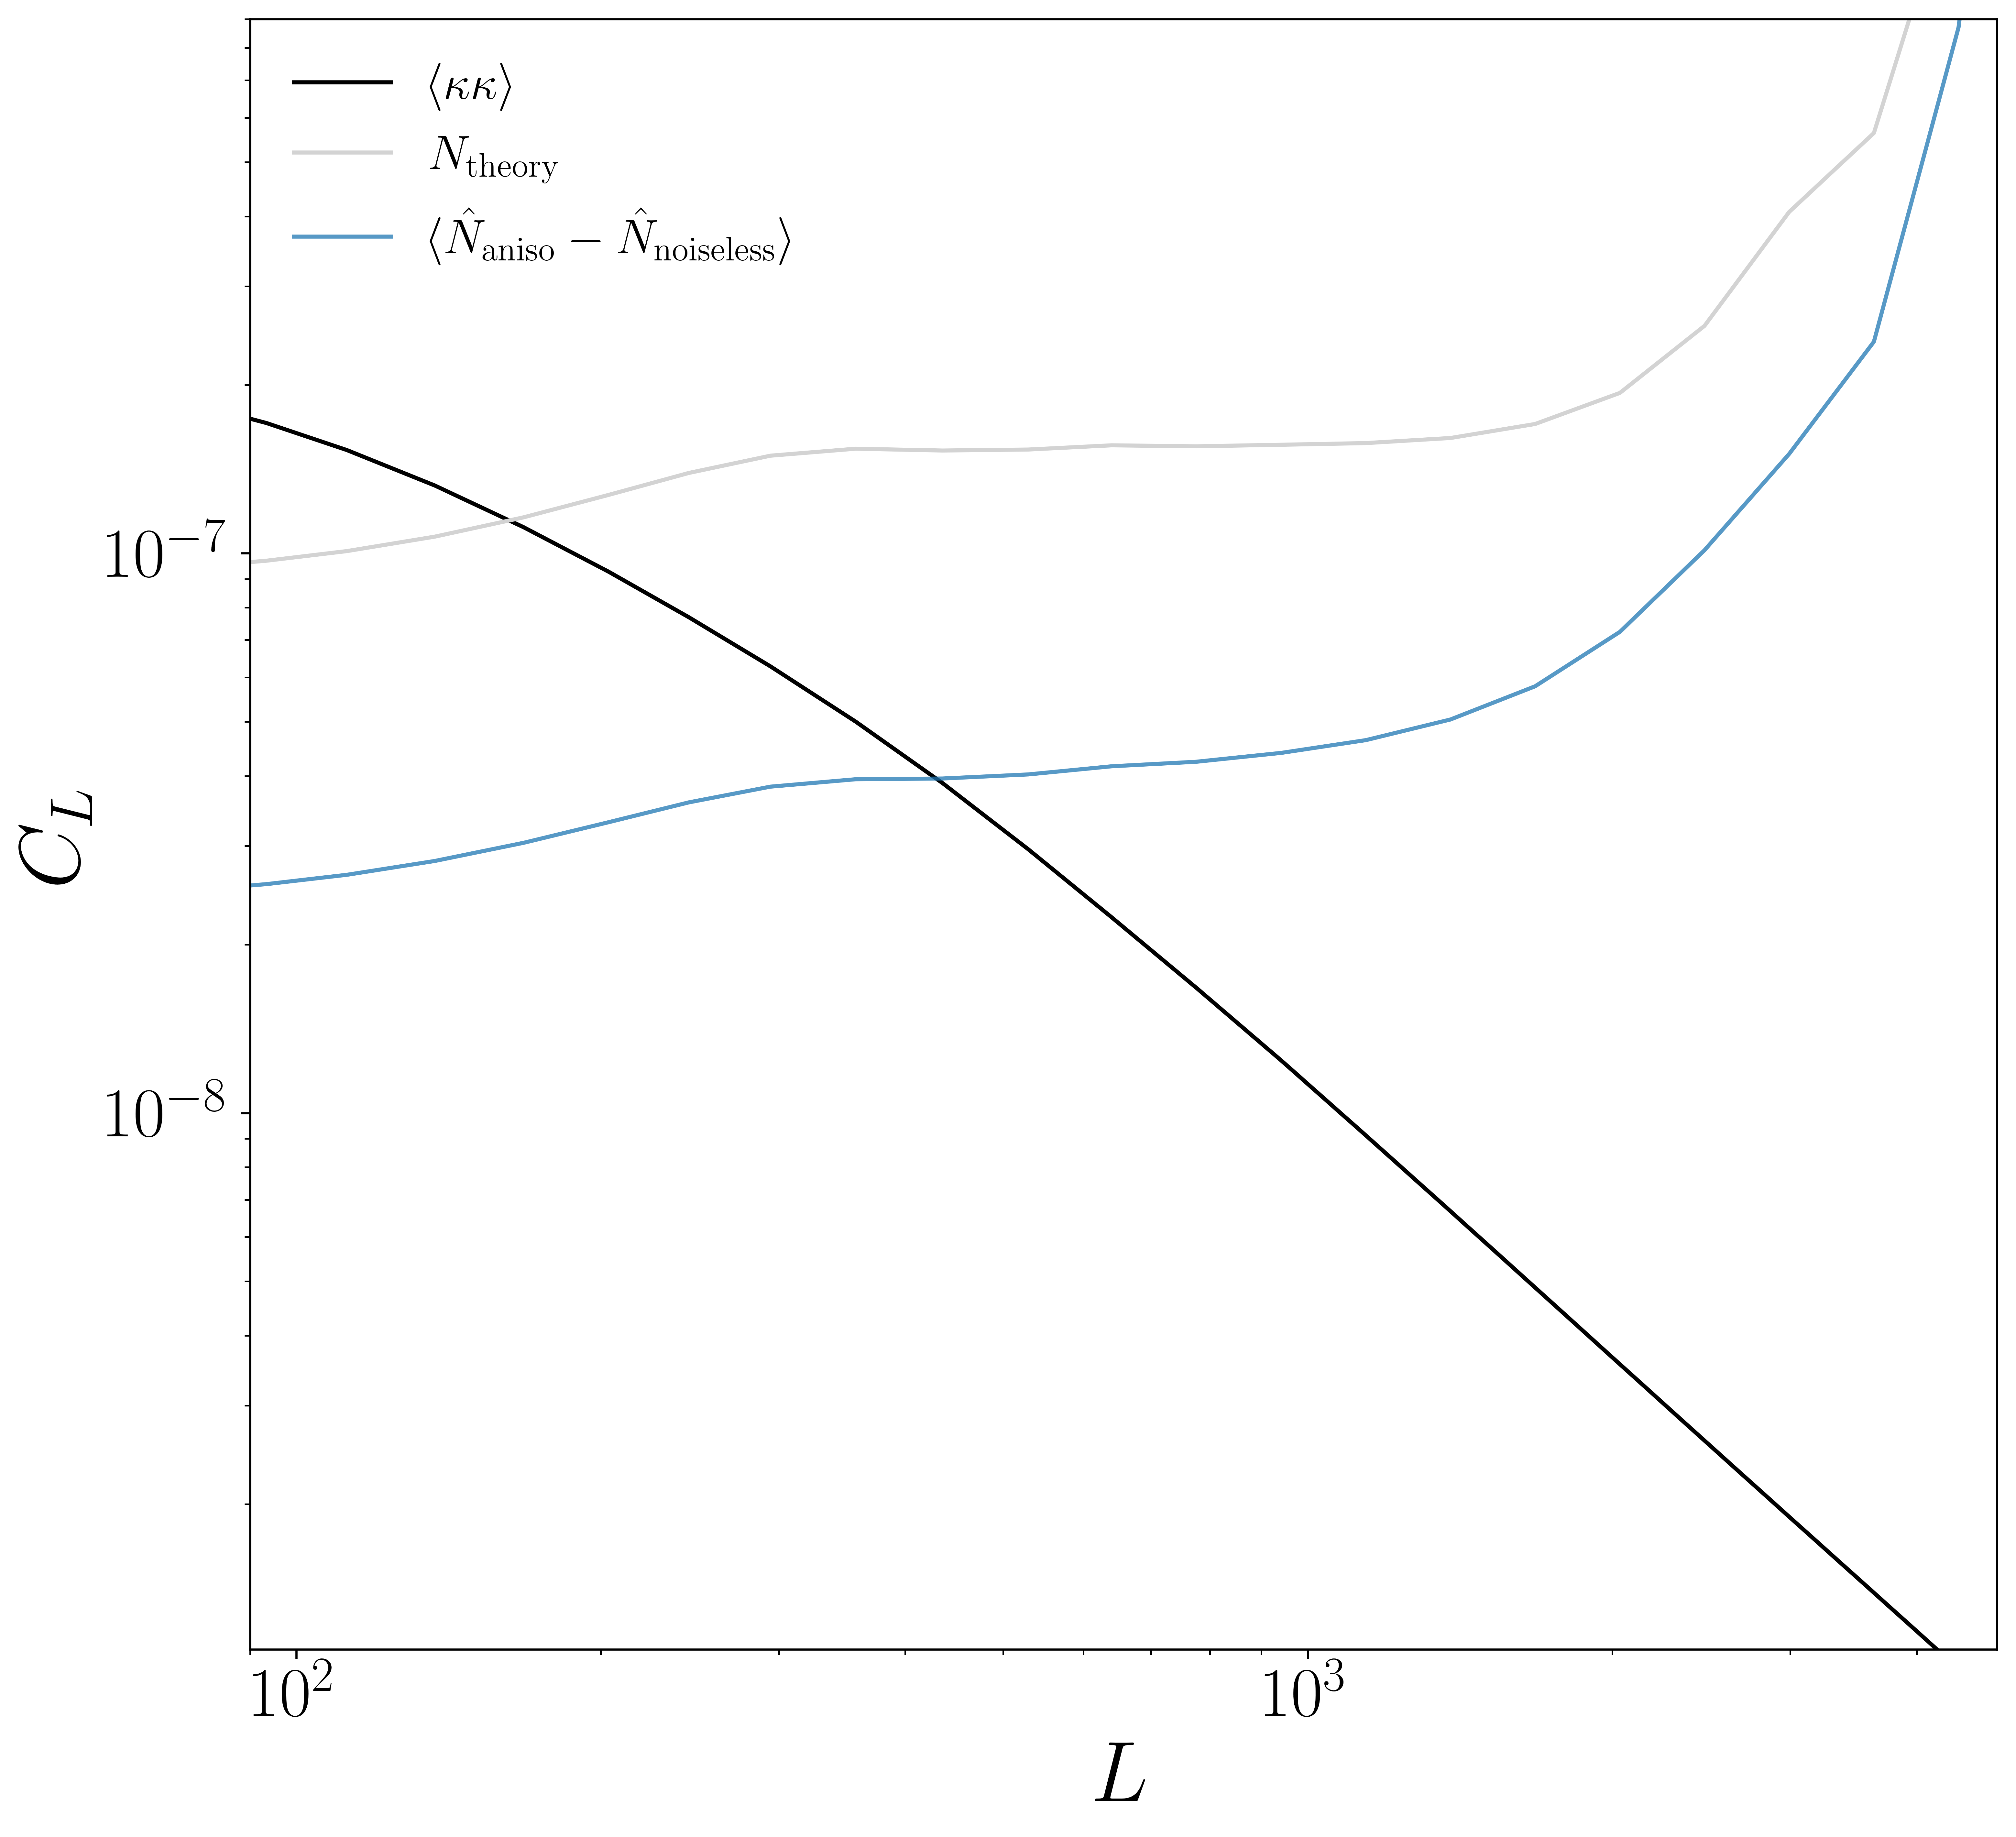

In [28]:
fig = plt.figure(figsize =(12, 14), dpi=600)

axs=[fig.add_axes((0.2,0.2,.75,.6))]
ax =axs[0]


plt.rcParams['text.usetex'] = True

plt.rcParams['font.size'] = 26

ell = baseMap.l.flatten()
theory=[fKK,fNqCmb_fft]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
#         L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
#         ClExpected = np.array(list(map(f, L)))
    L, ClExpected= baseMap.binTheoryPowerSpectrum(f, nBins=nBins)
    toPlot = np.where(ClExpected>0)
    ax.plot(L[toPlot], ClExpected[toPlot], sty, label=l)



ax.set_xscale('log')
ax.set_xlabel(r'$L$', fontsize=32)
ax.set_ylabel(r'$C_L$', fontsize=32)


ax.set_yscale('log')
ax.set_xlim(90,4800)
ax.set_ylim(1.1e-9,.9e-6)

ax.plot(deltaMask_mean[0], deltaMask_mean[1], alpha=0.75, label=r'$$\langle {\hat N_{\rm aniso}} - \hat N_{\rm noiseless} \rangle$$')
plt.legend(frameon=False)

In [24]:
f = open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/mean_field_nhat_aniso_1200x1200_20x20.pkl', 'wb') 
pickle.dump(deltaMask_mean, f)
f.close()


In [25]:
f = open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/mean_field_nhat_aniso_1200x1200_20x20_intermediate_0.pkl', 'wb') 
pickle.dump(results, f)
f.close()